[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Multivariate_Occupancy_Lags.ipynb)

# Multivariate Occupancy Example
--------------------------------------------------
**Dr. Dave Wanik - University of Connecticut**

Let's see if we can predict if it's a room is occupied as a function of environmental data.

Link: http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

Same flow as before, just need to prep our data differently. For now, we ignore the time dimension but we could resample to a regular resolution.

Wow - also a nice example: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Read in data
Check for missing values, make some plots.

In [ ]:
# Dataset initially sourced from LuisM78’s GitHub repository:
# url = 'https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/datatest.txt'
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module4_Files/datatest.txt"

# read the data
df = pd.read_csv(url)
print(df.info())
df.head(n=15) # nice complete data! this will allow us to check our work later

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB
None


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1
145,2015-02-02 14:23:59,23.7600,26.260,568.666667,790.000000,0.004779,1
146,2015-02-02 14:25:00,23.7300,26.290,536.333333,798.000000,0.004776,1
147,2015-02-02 14:25:59,23.7540,26.290,509.000000,797.000000,0.004783,1
148,2015-02-02 14:26:59,23.7540,26.350,476.000000,803.200000,0.004794,1
149,2015-02-02 14:28:00,23.7360,26.390,510.000000,809.000000,0.004796,1


In [ ]:
# count of occupancy
df['Occupancy'].value_counts() # not perfectly balanced, but that's OK

0    1693
1     972
Name: Occupancy, dtype: int64

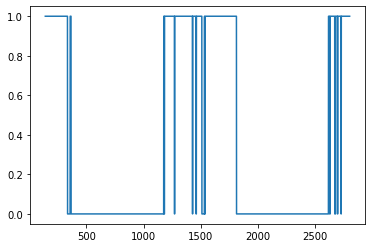

In [ ]:
# visualize the data
df['Occupancy'].plot()
plt.show()

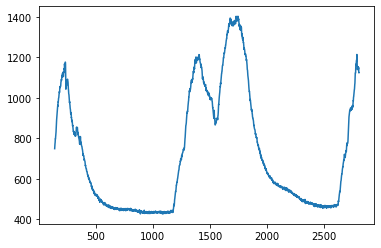

In [ ]:
# visualize the data
df['CO2'].plot()
plt.show()

In [ ]:
# drop the date column
df.drop(['date'], inplace=True, axis=1)
print(df.shape)
df.head()

(2665, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,23.7000,26.272,585.200000,749.200000,0.004764,1
141,23.7180,26.290,578.400000,760.400000,0.004773,1
142,23.7300,26.230,572.666667,769.666667,0.004765,1
143,23.7225,26.125,493.750000,774.750000,0.004744,1
144,23.7540,26.200,488.600000,779.000000,0.004767,1


In [ ]:
# link: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# we will probably drop the Y variable before running this

from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# now let's prep the data - just processing X
tmp = series_to_supervised(df, n_in=3, n_out=1)

We can do some clean-up here and get rid of the y columns we don't need (unless we want to use prior timesteps!) It's your choice - do you want to use past values of y to make a prediction - or just use the X variables?

In [ ]:
print(tmp.info())
tmp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2662 entries, 143 to 2804
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-3)  2662 non-null   float64
 1   var2(t-3)  2662 non-null   float64
 2   var3(t-3)  2662 non-null   float64
 3   var4(t-3)  2662 non-null   float64
 4   var5(t-3)  2662 non-null   float64
 5   var6(t-3)  2662 non-null   float64
 6   var1(t-2)  2662 non-null   float64
 7   var2(t-2)  2662 non-null   float64
 8   var3(t-2)  2662 non-null   float64
 9   var4(t-2)  2662 non-null   float64
 10  var5(t-2)  2662 non-null   float64
 11  var6(t-2)  2662 non-null   float64
 12  var1(t-1)  2662 non-null   float64
 13  var2(t-1)  2662 non-null   float64
 14  var3(t-1)  2662 non-null   float64
 15  var4(t-1)  2662 non-null   float64
 16  var5(t-1)  2662 non-null   float64
 17  var6(t-1)  2662 non-null   float64
 18  var1(t)    2662 non-null   float64
 19  var2(t)    2662 non-null   float64
 20  var3(t

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
143,23.7000,26.272,585.200000,749.200000,0.004764,1.0,23.7180,26.290,578.400000,760.400000,...,572.666667,769.666667,0.004765,1.0,23.7225,26.125,493.750000,774.75,0.004744,1
144,23.7180,26.290,578.400000,760.400000,0.004773,1.0,23.7300,26.230,572.666667,769.666667,...,493.750000,774.750000,0.004744,1.0,23.7540,26.200,488.600000,779.00,0.004767,1
145,23.7300,26.230,572.666667,769.666667,0.004765,1.0,23.7225,26.125,493.750000,774.750000,...,488.600000,779.000000,0.004767,1.0,23.7600,26.260,568.666667,790.00,0.004779,1
146,23.7225,26.125,493.750000,774.750000,0.004744,1.0,23.7540,26.200,488.600000,779.000000,...,568.666667,790.000000,0.004779,1.0,23.7300,26.290,536.333333,798.00,0.004776,1
147,23.7540,26.200,488.600000,779.000000,0.004767,1.0,23.7600,26.260,568.666667,790.000000,...,536.333333,798.000000,0.004776,1.0,23.7540,26.290,509.000000,797.00,0.004783,1


In [ ]:
# here are X and y
y = tmp['var6(t)']
X = tmp.drop(['var6(t)'], axis=1)
print(X.shape, y.shape)

(2662, 23) (2662,)


In [ ]:
# for fun, you can delete previous occupancy
del X['var6(t-1)']
del X['var6(t-2)']
del X['var6(t-3)']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2662 entries, 143 to 2804
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-3)  2662 non-null   float64
 1   var2(t-3)  2662 non-null   float64
 2   var3(t-3)  2662 non-null   float64
 3   var4(t-3)  2662 non-null   float64
 4   var5(t-3)  2662 non-null   float64
 5   var1(t-2)  2662 non-null   float64
 6   var2(t-2)  2662 non-null   float64
 7   var3(t-2)  2662 non-null   float64
 8   var4(t-2)  2662 non-null   float64
 9   var5(t-2)  2662 non-null   float64
 10  var1(t-1)  2662 non-null   float64
 11  var2(t-1)  2662 non-null   float64
 12  var3(t-1)  2662 non-null   float64
 13  var4(t-1)  2662 non-null   float64
 14  var5(t-1)  2662 non-null   float64
 15  var1(t)    2662 non-null   float64
 16  var2(t)    2662 non-null   float64
 17  var3(t)    2662 non-null   float64
 18  var4(t)    2662 non-null   float64
 19  var5(t)    2662 non-null   float64
dtypes: flo

In [ ]:
# take a peak at what it did
print(X.shape) # see how X has blown up?
print(y.shape)

# scroll up and make sure you understand this!
# y is a function of X (the previous n_steps observations!)

(2662, 20)
(2662,)


In [ ]:
# split the data into train and test partitions
# we will use 50% of the data for train, and 50% for validation
train_pct_index = int(0.5 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# pretty slick way of splitting your data using slicing!
# notice how we didn't do any shuffling (we don't want temporal leakage! keeps time series intact)

In [ ]:
# check the shape to be sure
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

# verify that this all adds up!

(2662, 20) (1331, 20) (1331, 20)
(2662,) (1331,) (1331,)


In [ ]:
# if we wanted to, we could do some scaling/normalization here, would not hurt!
# link: https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models

# do we need to fit this twice?!

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[1.26267621, 1.20117512, 2.06442737, ..., 2.05920375, 1.42609608,
        1.28807725],
       [1.34499082, 1.16434456, 2.00029635, ..., 2.0635311 , 1.41813741,
        1.28807725],
       [1.33984615, 1.15513692, 2.03669504, ..., 2.1003136 , 1.42896119,
        1.26764952],
       ...,
       [3.10446559, 0.72329862, 2.67973857, ..., 2.74292548, 1.7834718 ,
        1.81391127],
       [3.10446559, 0.65332056, 2.70833754, ..., 2.72561607, 1.77277536,
        1.82772885],
       [3.14562289, 0.66989431, 2.71613726, ..., 2.66070578, 1.77659552,
        1.84836239]])

# DNN one layer model

In [ ]:
# now let's build a model

# define model
model = Sequential()
model.add(Dense(30, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()

es = EarlyStopping(monitor='val_acc', mode='max',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)


# fit model (uses early stopping)
model.fit(X_train, y_train,
          epochs=500,
          batch_size=10,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                630       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
107/107 [==============================] - 2s 10ms/step - loss: 33.3293 - acc: 0.7293 - val_loss: 0.9277 - val_acc: 0.9775
Epoch 2/500
107/107 [==============================] - 1s 6ms/step - loss: 0.7970 - acc: 0.9511 - val_loss: 0.6781 - val_acc: 0.9775
Epoch 3/500
107/107 [==============================] - 1s 5ms/step - loss: 1.0981 - acc: 0.9511 - val_loss: 0.9926 - val_acc: 0.9775
Epoch 4/500
107/107 [==============================] 

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[825  24]
 [ 11 471]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       849
           1       0.95      0.98      0.96       482

    accuracy                           0.97      1331
   macro avg       0.97      0.97      0.97      1331
weighted avg       0.97      0.97      0.97      1331



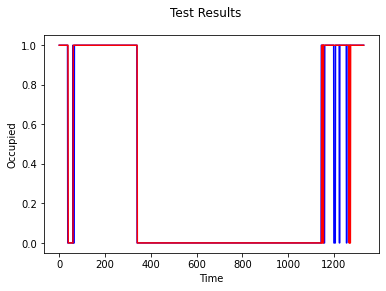

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
print(pred) # round them!

pred = np.round(pred,0)
print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Occupied')
plt.show()

Think about what a baseline model would be... is it possible to predict occupancy without previous Y data (just use X?) To do this, you would just need to delete some of the variables in tmp before splitting, then re-run the model.